In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path
from os import path
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)
from sklearn.utils import shuffle

#import data
def import_data(folder_name, file_name): 
    folder_path = './' + folder_name + '/' + file_name
    if path.exists(folder_path):   
        import_data.dataset = pd.read_csv(folder_path,skiprows=2) 
        import_data.dataset = np.array(import_data.dataset) 
        import_data.dataset = import_data.dataset[:-1,:-1] 
        return 1
    
    else:
        return -1

folder_name = 'individual_calib1'
test_folder_name = 'individual_test1'
file_number = 0
no_of_column = 4
FT_training = []   
uSkin_training = [] 
FT_test = []
uSkin_test = []


for i in range(80): 
    file_number += 1
    file_name = 'Position' + str(file_number) + '.txt'    
    if import_data(folder_name, file_name) != -1: 
        #offset with baseline                   
        import_data.dataset [:,8:import_data.dataset.shape[1]] -= import_data.dataset [:,8:import_data.dataset.shape[1]][1,:]
        data_loc = (i % no_of_column) * no_of_column + int(np.fix(i/no_of_column))  #mp.fix Rounds to nearest integer towards zero.
        
        for x in import_data.dataset[:,2:5]:
            FT_training.append(x) 
        for x in  import_data.dataset [:,data_loc*3+8:data_loc*3+11]:
            uSkin_training.append(x)  
    else:
        break 

file_number = 0
for i in range(80):
    file_number += 1
    file_name = 'Position' + str(file_number) + '.txt'    
    if import_data(test_folder_name, file_name) != -1: 
        #offset with baseline        
        import_data.dataset [:,8:import_data.dataset.shape[1]] -= import_data.dataset [:,8:import_data.dataset.shape[1]][1,:]
        data_loc = (i % no_of_column) * no_of_column + int(np.fix(i/no_of_column)) 
        for x in import_data.dataset[:,2:5]:
            FT_test.append(x)
        for x in  import_data.dataset [:,data_loc*3+8:data_loc*3+11]:
            uSkin_test.append(x)  
        
    else:
        break

FT_training = np.array(FT_training)
uSkin_training = np.array(uSkin_training)
FT_test = np.array(FT_test)
uSkin_test = np.array(uSkin_test)

#baseline = uSkin_test[1,:]
#uSkin_test -= baseline

FT_training[:,[0,1]] = FT_training[:,[1,0]] #swap x & y axis
FT_training[:,0:2] *= -1 #rotate x & y axis
FT_test[:,[0,1]] = FT_test[:,[1,0]] #swap x & y axis
FT_test[:,0:2] *= -1 #rotate x & y axis

#normalize uSkin data
max = 65536/ 4 # uSkin is 16 bit, +-x and +-y will be 15-bit each. In reality, the sensor output will never change more than 16,000 digits
FT_max = 10 # One taxel of uSkin typically can only measure up to 5N

uSkin_training /= max
uSkin_test /= max

# Shuffle the data for better learning, Since all positions are concatenated sequentially into a single matrix,
uSkin_training, FT_training = shuffle(uSkin_training, FT_training)

print('X_Train', uSkin_training.shape, '\n','y_Train', FT_training.shape,'\n',
      'X_Test', uSkin_test.shape, '\n','y_Test', FT_test.shape,'\n')

X_Train (441119, 3) 
 y_Train (441119, 3) 
 X_Test (121481, 3) 
 y_Test (121481, 3) 



### NN model

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import datetime
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
#rm -rf ./logs/

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)

Using:
	• TensorFlow version: 2.4.0
	• tf.keras version: 2.4.0


In [3]:
# Function to create model, required for KerasClassifier
def create_model(learn_rate,momentum): #kerasmodel.fit arguments are passed here
    # Build model
    model = Sequential()
    model.add(Dense(units=48, input_shape=(3,), activation='relu')) #input tensor & first hidden layer, 3 refers to the number of features in each input sample
    model.add(Dense(units=48,activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(units=3, activation='linear')) #output layers, 3 for X,Y,Z axis
    # Compile model
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer=optimizer , metrics=['mae'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


In [27]:
import timeit
start = timeit.default_timer()

# create model
model = KerasClassifier(build_fn=create_model, verbose=0,epochs=10 )
# define the grid search parameters (learning rate, dropout rate, epochs and number of neurons)
# define the grid search parameters (lr & momentum for SGD optimizer)
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3) #All examples are configured to use parallelism (n_jobs=-1)
                                                                             # To kill the process and change the code to not perform the grid search in parallel, set n_jobs=1
grid_result = grid.fit(uSkin_training, FT_training)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

stop = timeit.default_timer()
print('Time: ', stop - start) 


Best: nan using {'learn_rate': 0.001, 'momentum': 0.0}
Time:  3679.578263776999


In [4]:
model1 = Sequential()
model1.add(Dense(units=48, input_shape=(3,), activation='relu')) #input tensor & first hidden layer, 3 refers to the number of features in each input sample
model1.add(Dense(units=48,activation='relu'))
model1.add(layers.Dropout(0.3))
model1.add(Dense(units=3, activation='linear')) #output layers, 3 for X,Y,Z axis
# Compile model
optimizer = SGD(lr=0.001, momentum=0.0)
model1.compile(loss='mse', optimizer=optimizer , metrics=['mae'])

In [5]:
# Fit the model
import timeit
start = timeit.default_timer()

model1.fit(
    uSkin_training, FT_training, 
    epochs=5, 
    #callbacks=[PlotLossesKeras()],
    #callbacks=[tensorboard_callback],
    verbose=1,
    # Calculate validation results on x% of the training data
    validation_split = 0.2)

stop = timeit.default_timer()
print('Time: ', stop - start) 

Epoch 1/5
11028/11028 [==============================] - 14s 1ms/step - loss: 1.1455 - mae: 0.6695 - val_loss: 0.2286 - val_mae: 0.3205
Epoch 2/5
11028/11028 [==============================] - 13s 1ms/step - loss: 0.2858 - mae: 0.3711 - val_loss: 0.2173 - val_mae: 0.3109
Epoch 3/5
11028/11028 [==============================] - 16s 1ms/step - loss: 0.2676 - mae: 0.3576 - val_loss: 0.2099 - val_mae: 0.3066
Epoch 4/5
11028/11028 [==============================] - 13s 1ms/step - loss: 0.2566 - mae: 0.3496 - val_loss: 0.2050 - val_mae: 0.3027
Epoch 5/5
11028/11028 [==============================] - 14s 1ms/step - loss: 0.2489 - mae: 0.3439 - val_loss: 0.2005 - val_mae: 0.2995
Time:  69.028234908


In [6]:
# Test the model and Predict the outputs
prediction = model1.predict(uSkin_test)

In [43]:
prediction.shape, FT_test.shape

((121481, 3), (121481, 3))

In [7]:
y1_predict= prediction[:,0]
y2_predict= prediction[:,1]
y3_predict= prediction[:,2]

y1_true= FT_test[:,0]
y2_true= FT_test[:,1]
y3_true= FT_test[:,2]

print(y1_predict.shape, y2_predict.shape, y3_predict.shape,'\n',y1_true.shape, y2_true.shape, y3_true.shape)

(121481,) (121481,) (121481,) 
 (121481,) (121481,) (121481,)


#### Evaluation

1. The Coefficient of Determination

In [ ]:
import tensorflow_addons as tfa

In [ ]:
import tensorflow_addons as tfa
tfa.metrics.RSquare(
    name= 'r_square',
    dtype = None,
    y_shape= (3,),
    multioutput = 'uniform_average',
    num_regressors = 0,
    **kwargs )

In [ ]:
print('R-squared is : ' + str()

2. Error Metrics

In [70]:
tf.keras.losses.MeanAbsoluteError(name="mean_absolute_error")
mae = tf.keras.losses.MeanAbsoluteError()
print('Over-all MAE is : ' + str(mae(FT_test, prediction).numpy()))
print('X-axis MAE is : ' + str(mae(y1_true, y1_predict).numpy()))
print('Y-axis MAE is : ' + str(mae(y2_true, y2_predict).numpy()))
print('Z-axis MAE is : ' + str(mae(y3_true, y2_predict).numpy()))

Over-all MAE is : 0.2665778
X-axis MAE is : 0.32319805
Y-axis MAE is : 0.26568
Z-axis MAE is : 2.9896336


In [9]:
tf.keras.losses.MeanAbsoluteError(name="mean_absolute_error")
mae = tf.keras.losses.MeanAbsoluteError()
print('Over-all MAE is : ' + str(mae(FT_test, prediction).numpy())+' with standard deviation of ' + str(np.std(FT_test - prediction)))
print('X-axis MAE is : ' + str(mae(y1_true, y1_predict).numpy())+' with standard deviation of ' + str(np.std(y1_true - y1_predict)))
print('Y-axis MAE is : ' + str(mae(y2_true, y2_predict).numpy())+' with standard deviation of ' + str(np.std(y2_true - y2_predict)))
print('Z-axis MAE is : ' + str(mae(y3_true, y2_predict).numpy())+' with standard deviation of ' + str(np.std(y3_true - y3_predict)))


Over-all MAE is : 0.2639248 with standard deviation of 0.3753904550910389
X-axis MAE is : 0.23732063 with standard deviation of 0.3504964831307495
Y-axis MAE is : 0.24836256 with standard deviation of 0.3584727482763482
Z-axis MAE is : 2.9483588 with standard deviation of 0.4108068981623903


3. Correlation between Y and Ŷ

In [37]:
start_range = 1
full_range = len(prediction)
end_range = 20000
#end_range = full_range # uncomment to plot everything

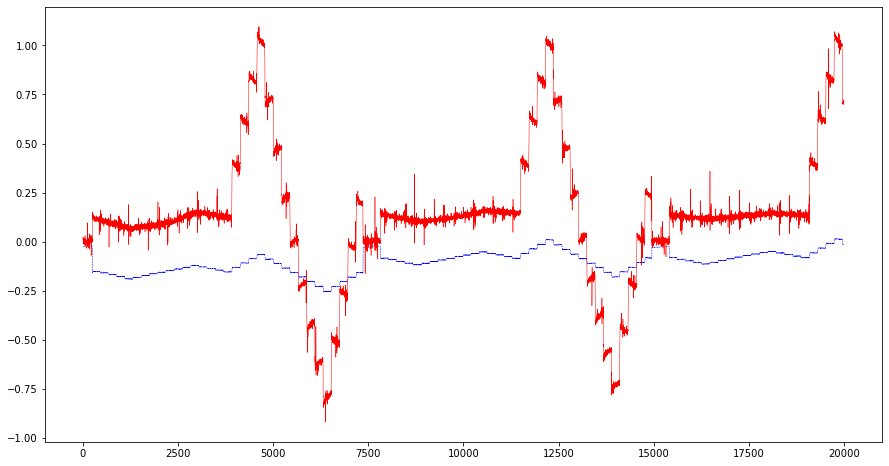

In [38]:
# o/p here is x-axis

plt.figure(figsize=(15,8))
plt.plot(y1_predict[start_range:end_range], "b--", linewidth = 0.5)
plt.plot(y1_true[start_range:end_range], 'r', linewidth = 0.5)

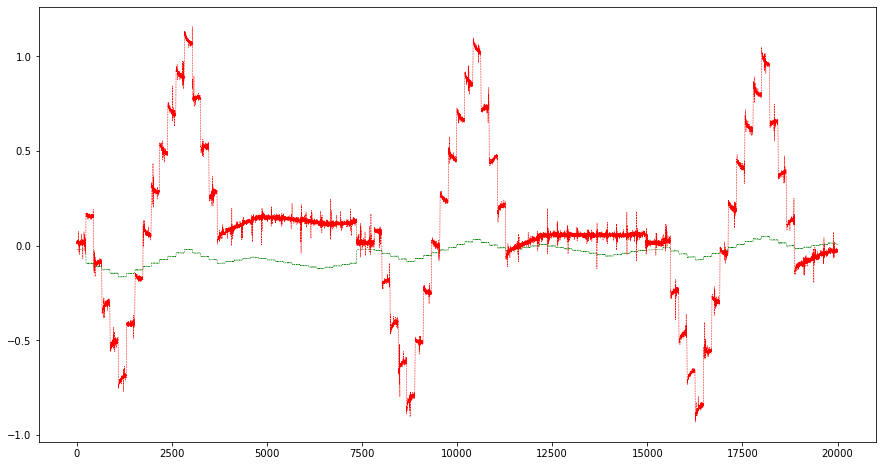

In [39]:
# o/p here is y-axis

plt.figure(figsize=(15,8))
plt.plot(y2_predict[start_range:end_range], "g--", linewidth = 0.5)
plt.plot(y2_true[start_range:end_range], 'r--', linewidth = 0.5)

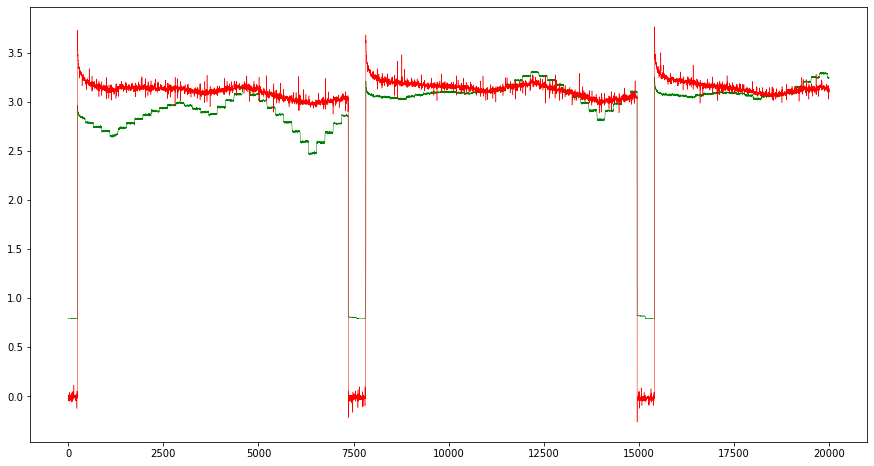

In [40]:
# o/p here is Z-axis

plt.figure(figsize=(15,8))
plt.plot(y3_predict[start_range:end_range], "g", linewidth = 0.5)
plt.plot(y3_true[start_range:end_range], 'r', linewidth = 0.5)

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(prediction[start_range:end_range,0], "b--", linewidth = 0.5)
plt.plot(prediction[start_range:end_range,1], "g--", linewidth = 0.5)
plt.plot(prediction[start_range:end_range,2], "r--", linewidth = 0.5)

plt.plot(FT_test[start_range:end_range,0], 'b', linewidth = 0.5)
plt.plot(FT_test[start_range:end_range,1], 'g', linewidth = 0.5)
plt.plot(FT_test[start_range:end_range,2], 'r', linewidth = 0.5)